In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/customer_act.zip

Archive:  /content/drive/MyDrive/customer_act.zip
  inflating: customer_login_history.csv  
  inflating: invoice_history.csv     
  inflating: static_data.csv         
  inflating: transfer_history.csv    


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

sns.set(font_scale=1)
figsize(10, 10)

In [58]:
# EXPLORE STATIC DATA
df_static = pd.read_csv('/content/static_data.csv')
df_static = df_static.rename(columns={'Unnamed: 0': 'index'})
df_static.set_index('index', inplace=True)
df_static.drop('PARTY_ID.1', inplace=True, axis=1)
df_static = df_static.drop_duplicates()
df_static.loc[:, 'CREATED_ON'] = df_static.CREATED_ON.astype('datetime64')
df_static.loc[:, 'LAST_LOGIN'] = df_static.LAST_LOGIN.astype('datetime64')

# Replace the None values in COUNTY with the mode
df_static['COUNTY'].fillna(df_static.COUNTY.mode()[0], inplace=True)
df_static.groupby('COUNTY').agg(lambda x: x.mode()).REGION

# Replace the None values in REGION with the mode of its COUNTY
county_mode = df_static.groupby('COUNTY').agg(lambda x: x.mode()).REGION
df_static.loc[df_static.REGION.isnull(), 'REGION'] = county_mode[df_static.loc[df_static.REGION.isnull(), 'COUNTY'].values].values
df_static.loc[:, 'REGION'] = df_static.REGION.astype('int')

party_ids = df_static.PARTY_ID

df_static

,PARTY_ID,CREATED_ON,LAST_LOGIN,LOB_CODE,SIZE,PACKAGE,REGION,COUNTY
index,,,,,,,,
0,233823894,2017-03-22 14:30:00,2017-03-22 14:30:54,49414.0,5-9 fő,Inbox,1,Pest
1,233823896,2017-03-23 12:48:00,2017-03-23 12:48:31,NaN,2000-4999 fő,Inbox,1,Pest
2,233823898,2017-03-23 13:46:00,2017-03-23 15:19:06,70224.0,1 fő,Inbox,1,Pest
3,233823900,2017-03-27 06:40:00,2017-03-27 06:44:06,81104.0,3-4 fő,Inbox,2,Pest
4,233823901,2017-03-27 06:43:00,2017-03-27 06:46:13,46514.0,5-9 fő,Inbox,1,Pest
...,...,...,...,...,...,...,...,...
26052,684845716,2020-10-16 13:40:00,2020-10-19 06:44:16,45114.0,2 fő,Inbox Extra Free (= Inbox Extra),1,Pest
26053,684845718,2020-10-16 15:58:00,2020-10-16 16:40:03,68104.0,0 fő,Inbox,1,Pest
26054,685181166,2020-10-18 10:38:00,2020-10-18 10:38:37,56104.0,3-4 fő,Inbox,6,Csongrád


In [59]:
present_date = df_static.CREATED_ON.max()
first_date = df_static.CREATED_ON.min()
print(f'present date:{present_date} first date:{first_date}')

present date:2020-10-26 18:55:00 first date:1970-01-01 00:00:00


The counts of each county in df_static:
Pest                      10712
Győr-Moson-Sopron          1277
Bács-Kiskun                1234
Fejér                      1178
Hajdú-Bihar                1130
Borsod-Abaúj-Zemplén       1087
Baranya                    1056
Veszprém                   1029
Komárom-Esztergom           973
Csongrád                    901
Szabolcs-Szatmár-Bereg      845
Somogy                      709
Zala                        654
Jász-Nagykun-Szolnok        650
Vas                         607
Heves                       592
Tolna                       527
Békés                       510
Nógrád                      307
Name: COUNTY, dtype: int64


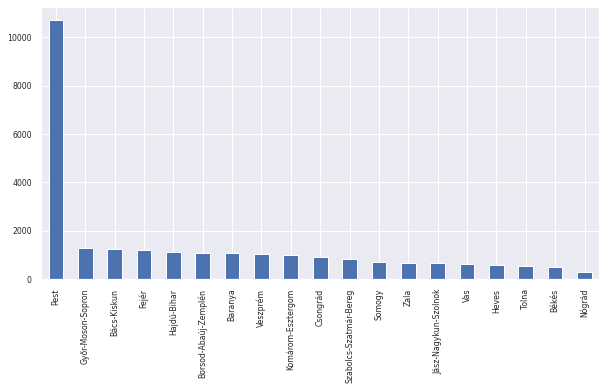

In [60]:
# check the county columns 
print(f"The counts of each county in df_static:\n{df_static.COUNTY.value_counts()}")
plt.figure(figsize=(10,5))
df_static.COUNTY.value_counts().plot(kind='bar', rot=90)

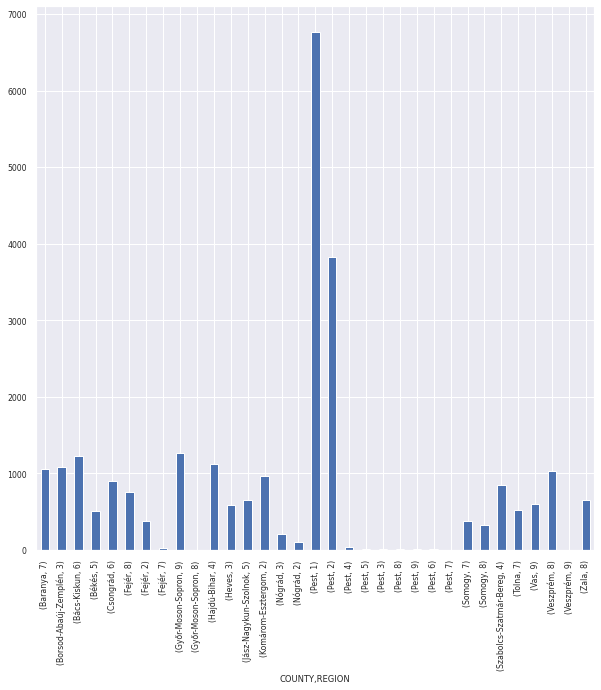

In [61]:
plt.figure(figsize=(10,10))
df_static.groupby('COUNTY').REGION.value_counts().plot(kind='bar', rot=90)

In [62]:
df_static.PACKAGE.value_counts()

Inbox Extra Free (= Inbox Extra)    9738
Inbox                               8159
Freemium                            2285
ExleX                               2202
S                                   1635
Hibernált                            942
M                                    699
Inbox Extra Standard                 108
Promó                                 66
Inbox Extra Pro                       22
Inbox Extra                           15
Name: PACKAGE, dtype: int64

In [63]:
df_static.SIZE.value_counts()

0 fő            4779
5-9 fő          3132
1 fő            3024
3-4 fő          2612
10-19 fő        2379
2 fő            1963
20-49 fő        1681
50-99 fő         563
100-149 fő       144
Ismeretlen        93
150-199 fő        66
200-249 fő        48
500-999 fő        34
300-499 fő        34
250-299 fő        16
1000-1999 fő      11
2000-4999 fő       5
5000 főtől         2
Name: SIZE, dtype: int64

In [64]:
print(f'missing value for the SIZE :{len(df_static[df_static.SIZE.isnull()])}')
print(f'missing value for the PACKAGE :{len(df_static[df_static.PACKAGE.isnull()])}')
print(f'missing value for the LOB_CODE :{len(df_static[df_static.LOB_CODE.isnull()])}')

missing value for the SIZE :5392
missing value for the PACKAGE :107
missing value for the LOB_CODE :6231


In [65]:
df_login = pd.read_csv('/content/customer_login_history.csv')
df_login = df_login.rename(columns={'Unnamed: 0': 'index'})
df_login.set_index('index', inplace=True)
df_login = df_login.drop_duplicates()
df_login['LAST_LOGIN'] = df_login.LAST_LOGIN.astype('datetime64')

party_ids = party_ids[party_ids.isin(df_login.PARTY_ID)]

df_login

,PARTY_ID,LAST_LOGIN
index,,
0,233823836,2017-01-31 11:28:34
1,233823838,2017-06-12 11:22:53
2,233823838,2017-06-14 13:41:01
3,233823838,2017-06-15 08:31:44
4,233823838,2017-06-22 09:56:56
...,...,...
586176,685219705,2020-10-21 17:58:21
586177,685231467,2020-10-22 08:55:16
586178,685231471,2020-10-22 08:52:35


In [67]:
# Check matching between the most recent login date in df_login and the last login date in df_static for each party_id in df_login
# Print only non-matching dates
#party_id = 233823838
df_test = df_login[['PARTY_ID']].drop_duplicates()
def fun(party_id):
    date1 = df_login.groupby('PARTY_ID').get_group(party_id).LAST_LOGIN.max()
    date2 = df_static.loc[df_static.PARTY_ID == party_id, 'LAST_LOGIN'].iloc[0]
    if date1 != date2:
        print(f"party_id: {party_id}  static: {date2}  login_hist: {date1}  login_hist - static: {date1 - date2}")
for t, tt in df_test.iterrows():
    try:
        fun(tt.iloc[0])
    except KeyboardInterrupt:
        break

party_id: 233823840  static: 2020-10-26 14:12:18  login_hist: 2020-10-26 10:14:14  login_hist - static: -1 days +20:01:56
party_id: 233823849  static: 2020-10-26 13:15:26  login_hist: 2020-10-26 10:04:39  login_hist - static: -1 days +20:49:13
party_id: 233823853  static: 2020-10-26 16:41:16  login_hist: 2020-10-26 09:35:38  login_hist - static: -1 days +16:54:22
party_id: 233823855  static: 2017-03-31 11:57:00  login_hist: 2017-03-31 11:57:06  login_hist - static: 0 days 00:00:06
party_id: 233823856  static: 2017-03-31 11:51:00  login_hist: 2017-03-31 11:51:20  login_hist - static: 0 days 00:00:20


In [68]:
df_invoice = pd.read_csv('/content/invoice_history.csv')
df_invoice = df_invoice.rename(columns={'Unnamed: 0': 'index'})
df_invoice.set_index('index', inplace=True)

party_ids = party_ids[party_ids.isin(df_invoice.PARTY_ID)]

df_invoice

,INVOICE_ID,PARTY_ID,CURRENCY,TAXEXCLUSIVEAMOUNT,TAXINCLUSIVEAMOUNT,PAYABLEAMOUNT,ISSUEDATE,TAXPOINTDATE,DUEDATE
index,,,,,,,,,
0,214341229,233824028,HUF,838701.0,1065150.0,1065150.0,2017-05-01,2017-05-01,2017-05-08
1,214464014,233824108,HUF,175000.0,222250.0,222250.0,2017-05-05,2017-05-31,2017-06-05
2,215035971,233824067,EUR,510.0,647.7,647.7,2017-05-07,2017-05-07,2017-05-15
3,215035983,233824067,EUR,130.0,165.1,165.1,2017-05-07,2017-05-07,2017-05-15
4,215035988,233824067,HUF,40581.0,51538.0,51538.0,2017-05-07,2017-05-07,2017-05-15
...,...,...,...,...,...,...,...,...,...
636909,685206566,250603794,HUF,919926.0,1168306.0,1168306.0,2020-10-20,2020-10-20,2020-11-04
636910,685206567,594633811,HUF,-36800.0,-46736.0,-46736.0,2020-10-20,2020-10-19,2020-11-03
636911,685206568,591638361,HUF,1740000.0,2209800.0,2209800.0,2020-10-20,2020-10-26,2020-10-26


In [69]:
df_transfer = pd.read_csv('/content/transfer_history.csv')
df_transfer = df_transfer.rename(columns={'Unnamed: 0': 'index'})
df_transfer.set_index('index', inplace=True)
df_transfer = df_transfer.drop_duplicates()

party_ids = party_ids[party_ids.isin(df_transfer.PARTY_ID)]

df_transfer

,TRANSFER_ID,PARTY_ID,CURRENCY,AMOUNT,VALUE_DATE
index,,,,,
0,369832601,240924299,HUF,500000.0,2018-08-22
1,369832704,323871147,HUF,190000.0,2018-08-22
2,369832705,349707008,HUF,1454874.0,2018-08-22
3,369832706,349707008,HUF,1502821.0,2018-08-22
4,369832784,240285235,HUF,369000.0,2018-08-22
...,...,...,...,...,...
307397,682694432,457359259,HUF,2273.0,2020-10-12
307398,682694636,345778398,HUF,152400.0,2020-10-12
307399,682694637,345778398,HUF,738640.0,2020-10-12


In [106]:
'''
!!!!!!!!!!!!!!!!!!   RUN EITHER THIS CELL OR THE ONE AFTER   !!!!!!!!!!!!!!!!!!

'''

# Create Customer Profiling DataFrame (df_profil) considering
# only party_ids that have data in all the tables
#
df_profil = pd.DataFrame(df_login.loc[df_login.PARTY_ID.isin(party_ids)].groupby('PARTY_ID').count().iloc[:, 0])
df_profil.columns = ['login_count']

df_profil['transfer_count'] = df_transfer.loc[df_transfer.PARTY_ID.isin(party_ids)].groupby('PARTY_ID').count().iloc[:, 0]

df_profil['tranfer_amount'] = df_transfer.loc[df_transfer.PARTY_ID.isin(party_ids)].groupby('PARTY_ID').AMOUNT.sum()

dff = df_static[['PARTY_ID', 'CREATED_ON']].copy()
dff = dff.loc[dff.PARTY_ID.isin(party_ids)]
dff['duration'] = present_date - dff.CREATED_ON
dff = dff.drop(columns=['CREATED_ON']).set_index('PARTY_ID')
df_profil['duration'] = dff
df_profil.loc[:, 'duration'] = df_profil.duration.apply(lambda x: x.days).astype(int)

# Normalize entries (/month)
df_profil.loc[:, 'login_count'] = round(df_profil.login_count / df_profil.duration * 30).astype(int)
df_profil.loc[:, 'transfer_count'] = round(df_profil.transfer_count / df_profil.duration * 30).astype(int)
df_profil['tranfer_amount'] = round(df_profil.tranfer_amount / df_profil.duration * 30).astype(int)

# Create new region column
dff = df_static[['PARTY_ID', 'COUNTY', 'REGION']].copy()
dff = dff.loc[dff.PARTY_ID.isin(party_ids)]
dff['region'] = dff.COUNTY + ' ' + dff.REGION.astype(str)
dff = dff.drop(columns=['COUNTY', 'REGION']).set_index('PARTY_ID')
df_profil['region'] = dff

df_profil

,login_count,transfer_count,tranfer_amount,duration,region
PARTY_ID,,,,,
233823838,0,0,64664,1362,Pest 2
233823841,3,0,3345,1341,Nógrád 2
233823849,18,8,2915518,1333,Pest 1
233823853,20,3,1802019,1333,Nógrád 2
233823971,13,5,5892810,1292,Pest 1
...,...,...,...,...,...
665282246,5,1,65217,46,Nógrád 3
665818950,13,1,1515,45,Pest 1
666202718,7,15,620620,44,Nógrád 2


In [107]:
# Create Customer Profiling DataFrame (df_profil) considering
# party_ids in df_login
#

# Create new login column
login_count = df_login.PARTY_ID.value_counts()
df_profil = pd.DataFrame(login_count)
df_profil.columns = ['login_count']

# Create new tranfer_count column
tranfer_count = df_transfer.PARTY_ID.value_counts()
df_profil['transfer_count'] = tranfer_count
df_profil.loc[:, 'transfer_count'] = df_profil.transfer_count.fillna(value=0).astype('int')

# Create new tranfer_amount column
total_tranfer_amount = df_transfer[['AMOUNT', 'PARTY_ID']].groupby(['PARTY_ID']).sum()
df_profil['tranfer_amount'] = total_tranfer_amount
df_profil.loc[:, 'tranfer_amount'] = df_profil.tranfer_amount.fillna(value=0).astype('int')

# Create new duration column
dff = df_static[['PARTY_ID', 'CREATED_ON']].copy()
dff['duration'] = present_date - dff.CREATED_ON
dff = dff.drop(columns=['CREATED_ON']).set_index('PARTY_ID')
df_profil['duration'] = dff
df_profil.loc[:, 'duration'] = df_profil.duration.apply(lambda x: x.days).astype(int)


# Normalize entries (/month)
df_profil.loc[:, 'login_count'] = round(df_profil.login_count / df_profil.duration * 30).astype(int)
df_profil.loc[:, 'transfer_count'] = round(df_profil.transfer_count / df_profil.duration * 30).astype(int)
df_profil['tranfer_amount'] = round(df_profil.tranfer_amount / df_profil.duration * 30).astype(int)

# Create new region column
dff = df_static[['PARTY_ID', 'COUNTY', 'REGION']].copy()
dff['region'] = dff.COUNTY + ' ' + dff.REGION.astype(str)
dff = dff.drop(columns=['COUNTY', 'REGION']).set_index('PARTY_ID')
df_profil['region'] = dff

df_profil.sort_values(by='login_count', ascending=False, inplace=True)
df_profil.head(20)

,login_count,transfer_count,tranfer_amount,duration,region
555758620,24,40,3257841,320,Tolna 7
390462164,24,87,11886167,731,Csongrád 6
416491156,23,28,11913297,655,Tolna 7
409045468,23,80,13831780,675,Pest 2
623688199,23,65,58890820,143,Pest 2
621704845,23,8,148270,149,Bács-Kiskun 6
240281370,23,56,12404958,1047,Tolna 7
323871073,23,49,5780960,893,Somogy 7
621746910,23,12,1338330,147,Győr-Moson-Sopron 9
628048358,22,0,62244,135,Komárom-Esztergom 2


In [95]:
# Normalize the data
df_profil.loc[:, 'tranfer_amount'] = preprocessing.normalize(df_profil[['tranfer_amount']], axis=0) 
df_profil.loc[:, 'duration'] = preprocessing.normalize(df_profil[['duration']], axis=0) 
df_profil.loc[:, 'login_count'] = preprocessing.normalize(df_profil[['login_count']], axis=0) 
df_profil.loc[:, 'transfer_count'] = preprocessing.normalize(df_profil[['transfer_count']], axis=0)
df_profil

,login_count,transfer_count,tranfer_amount,duration,region
PARTY_ID,,,,,
233823838,0.000000,0.000000,0.000265,0.041602,Pest 2
233823841,0.008323,0.000000,0.000014,0.040960,Nógrád 2
233823849,0.049935,0.013397,0.011947,0.040716,Pest 1
233823853,0.055483,0.005024,0.007384,0.040716,Nógrád 2
233823971,0.036064,0.008373,0.024146,0.039464,Pest 1
...,...,...,...,...,...
665282246,0.013871,0.001675,0.000267,0.001405,Nógrád 3
665818950,0.036064,0.001675,0.000006,0.001375,Pest 1
666202718,0.019419,0.025119,0.002543,0.001344,Nógrád 2


In [96]:
# One-Hot-Encoding of categorical features
indicators = pd.get_dummies(df_profil.region)
indicators.replace({1: 1}, inplace=True) # reduce one hot encoding distance (between True and False)
df_profil = df_profil.join(indicators, how='inner').drop(columns=['region'])
df_profil

,login_count,transfer_count,tranfer_amount,duration,Baranya 7,Borsod-Abaúj-Zemplén 3,Bács-Kiskun 6,Békés 5,Csongrád 6,Fejér 2,Fejér 8,Győr-Moson-Sopron 9,Hajdú-Bihar 4,Heves 3,Jász-Nagykun-Szolnok 5,Komárom-Esztergom 2,Nógrád 2,Nógrád 3,Pest 1,Pest 2,Pest 4,Pest 6,Pest 7,Somogy 7,Somogy 8,Szabolcs-Szatmár-Bereg 4,Tolna 7,Vas 9,Veszprém 8,Zala 8
PARTY_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
233823838,0.000000,0.000000,0.000265,0.041602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
233823841,0.008323,0.000000,0.000014,0.040960,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
233823849,0.049935,0.013397,0.011947,0.040716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
233823853,0.055483,0.005024,0.007384,0.040716,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
233823971,0.036064,0.008373,0.024146,0.039464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665282246,0.013871,0.001675,0.000267,0.001405,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
665818950,0.036064,0.001675,0.000006,0.001375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
666202718,0.019419,0.025119,0.002543,0.001344,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


[Text(0, 0.5, 'Within-groups sum of squares'),
 Text(0.5, 0, 'N'),
 Text(0.5, 1.0, 'Elbow Curve')]

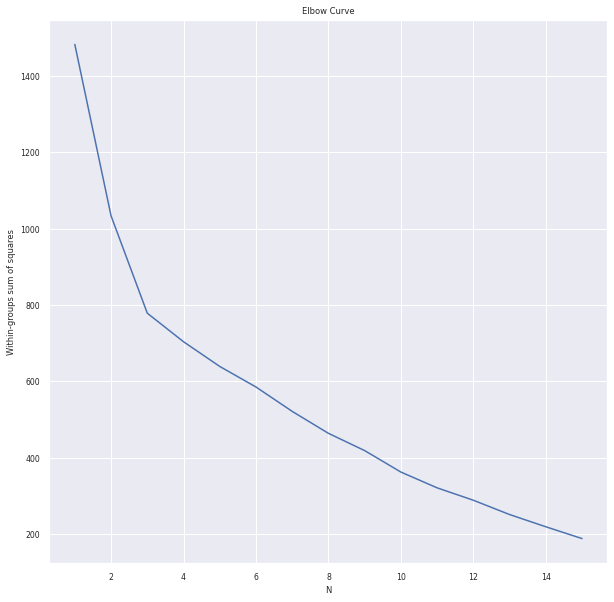

In [97]:
# Deciding n_clusters
from sklearn.cluster import KMeans
error_rates = []

for N in range(1, 16):
    kmeans = KMeans(n_clusters=N).fit(df_profil)
    error_rates.append(kmeans.inertia_)

ax = sns.lineplot(x=list(range(1, 16)), y=error_rates)
ax.set(xlabel='N', ylabel='Within-groups sum of squares', title='Elbow Curve')

In [98]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_profil)
df_profil['Cluster'] = kmeans.labels_.astype('str')
df_profil = pd.get_dummies(df_profil)

df_profil

,login_count,transfer_count,tranfer_amount,duration,Baranya 7,Borsod-Abaúj-Zemplén 3,Bács-Kiskun 6,Békés 5,Csongrád 6,Fejér 2,Fejér 8,Győr-Moson-Sopron 9,Hajdú-Bihar 4,Heves 3,Jász-Nagykun-Szolnok 5,Komárom-Esztergom 2,Nógrád 2,Nógrád 3,Pest 1,Pest 2,Pest 4,Pest 6,Pest 7,Somogy 7,Somogy 8,Szabolcs-Szatmár-Bereg 4,Tolna 7,Vas 9,Veszprém 8,Zala 8,Cluster_0,Cluster_1,Cluster_2
PARTY_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
233823838,0.000000,0.000000,0.000265,0.041602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
233823841,0.008323,0.000000,0.000014,0.040960,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
233823849,0.049935,0.013397,0.011947,0.040716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
233823853,0.055483,0.005024,0.007384,0.040716,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
233823971,0.036064,0.008373,0.024146,0.039464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665282246,0.013871,0.001675,0.000267,0.001405,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
665818950,0.036064,0.001675,0.000006,0.001375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
666202718,0.019419,0.025119,0.002543,0.001344,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


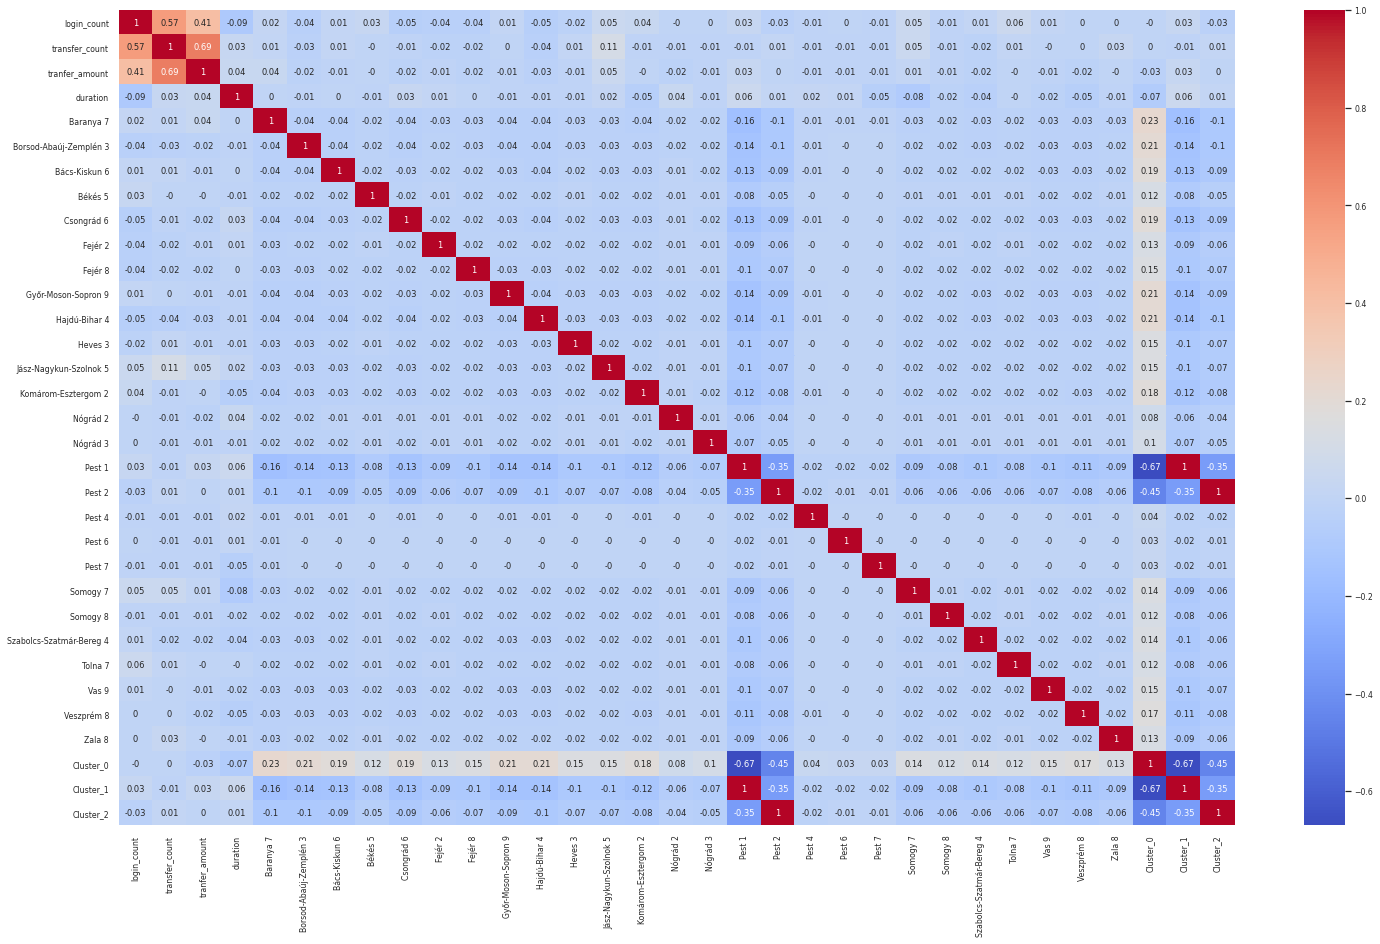

In [99]:
# Correlation matrix
plt.figure(figsize = (25, 15))
sns.set(font_scale=0.7)
sns.heatmap(round(df_profil.corr(), 2), annot=True, cmap='coolwarm')

In [100]:
# Considering only Pest 1 and Pest 2 regions
df_profil = df_profil[(df_profil['Pest 1'] == 1) | (df_profil['Pest 2'] == 1)]
df_profil = df_profil[['login_count', 'transfer_count', 'tranfer_amount', 'duration', 'Pest 1', 'Pest 2']]
df_profil

,login_count,transfer_count,tranfer_amount,duration,Pest 1,Pest 2
PARTY_ID,,,,,,
233823838,0.000000,0.000000,0.000265,0.041602,0,1
233823849,0.049935,0.013397,0.011947,0.040716,1,0
233823971,0.036064,0.008373,0.024146,0.039464,1,0
233824027,0.013871,0.001675,0.000096,0.039311,0,1
233824028,0.008323,0.001675,0.000006,0.039311,0,1
...,...,...,...,...,...,...
658283939,0.008323,0.003349,0.028611,0.001863,1,0
659508255,0.005548,0.001675,0.000129,0.001741,0,1
665818950,0.036064,0.001675,0.000006,0.001375,1,0


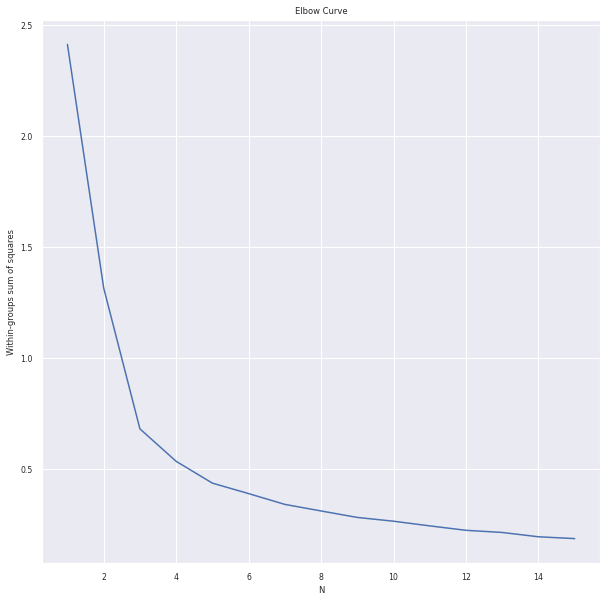

In [101]:
d = {1: 0.05}
dff = df_profil.replace({'Pest 1': d, 'Pest 2': d})
# Deciding n_clusters
from sklearn.cluster import KMeans
error_rates = []
for N in range(1, 16):
    kmeans = KMeans(n_clusters=N).fit(dff)
    error_rates.append(kmeans.inertia_)
ax = sns.lineplot(x=list(range(1, 16)), y=error_rates)
ax.set(xlabel='N', ylabel='Within-groups sum of squares', title='Elbow Curve')
plt.show()

In [102]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(dff)
dff['Cluster'] = kmeans.labels_.astype('str')
dff = pd.get_dummies(dff)

dff

,login_count,transfer_count,tranfer_amount,duration,Pest 1,Pest 2,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
PARTY_ID,,,,,,,,,,,
233823838,0.000000,0.000000,0.000265,0.041602,0.00,0.05,0,1,0,0,0
233823849,0.049935,0.013397,0.011947,0.040716,0.05,0.00,0,0,0,1,0
233823971,0.036064,0.008373,0.024146,0.039464,0.05,0.00,0,0,0,1,0
233824027,0.013871,0.001675,0.000096,0.039311,0.00,0.05,0,1,0,0,0
233824028,0.008323,0.001675,0.000006,0.039311,0.00,0.05,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
658283939,0.008323,0.003349,0.028611,0.001863,0.05,0.00,1,0,0,0,0
659508255,0.005548,0.001675,0.000129,0.001741,0.00,0.05,0,1,0,0,0
665818950,0.036064,0.001675,0.000006,0.001375,0.05,0.00,1,0,0,0,0


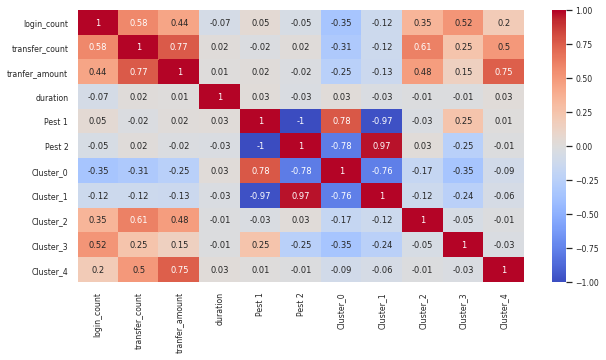

In [103]:
# Correlation matrix
plt.figure(figsize = (10, 5))
sns.set(font_scale=0.7)
sns.heatmap(round(dff.corr(), 2), annot=True, cmap='coolwarm')

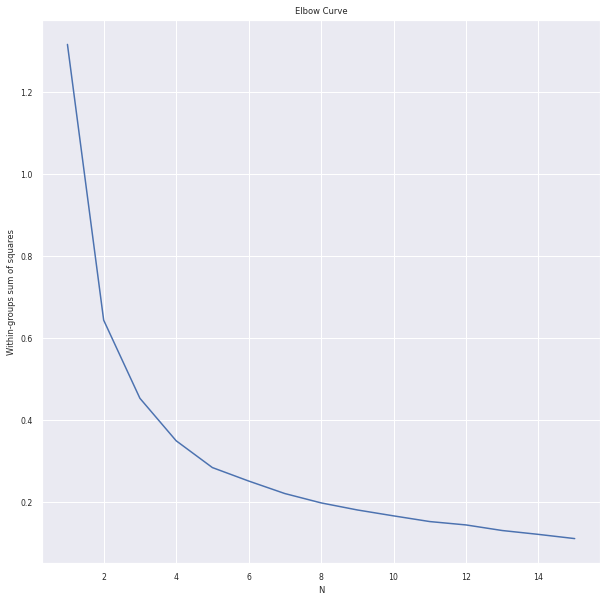

case: clusters# = 7


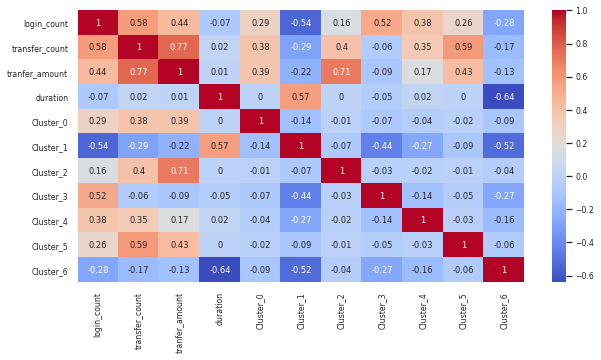

case: clusters# = 6


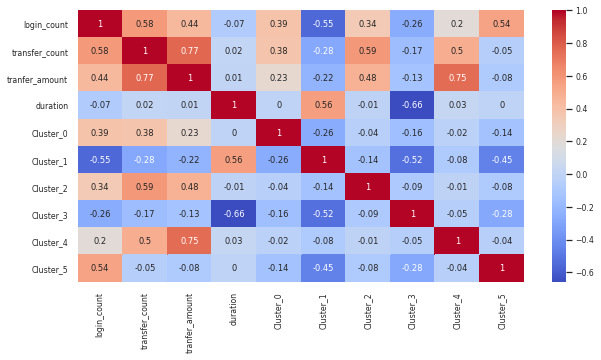

case: clusters# = 5


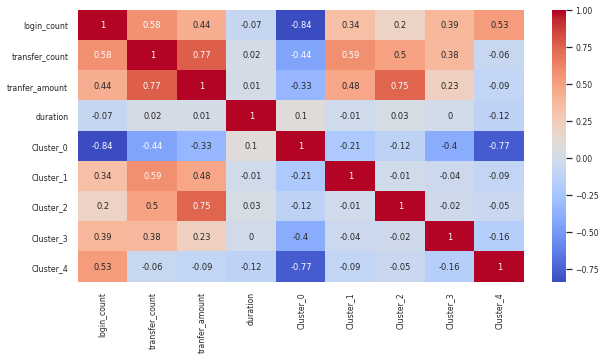

case: clusters# = 4


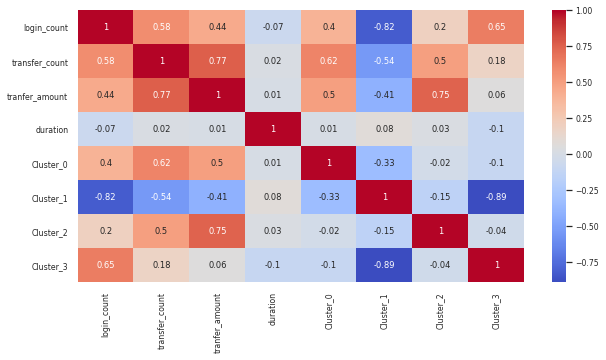

case: clusters# = 3


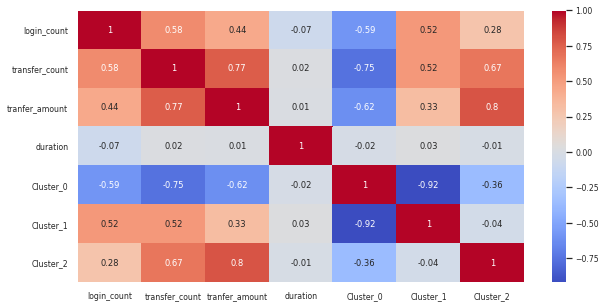

In [104]:
# Disregarding the region feature
df_profil = df_profil[['login_count', 'transfer_count', 'tranfer_amount', 'duration']]

# Deciding n_clusters
from sklearn.cluster import KMeans
error_rates = []
for N in range(1, 16):
    kmeans = KMeans(n_clusters=N).fit(df_profil)
    error_rates.append(kmeans.inertia_)
ax = sns.lineplot(x=list(range(1, 16)), y=error_rates)
ax.set(xlabel='N', ylabel='Within-groups sum of squares', title='Elbow Curve')
plt.show()

# Try different cases of number of clusters (from 3 to 7)
for i in range(7, 2, -1):
    print(f"case: clusters# = {i}")
    df_profil = df_profil[['login_count', 'transfer_count', 'tranfer_amount', 'duration']]
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_profil)
    df_profil['Cluster'] = kmeans.labels_.astype('str')
    df_profil = pd.get_dummies(df_profil)
    # Correlation matrix
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=0.7)
    sns.heatmap(round(df_profil.corr(), 2), annot=True, cmap='coolwarm')
    plt.show()